In [ ]:
pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

import numpy as np

import torch
import torch.nn.functional as F
from torch_geometric.data import Data

import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATConv
import networkx as nx
from collections import Counter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

In [ ]:
# Define column names
columns = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
           'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted',
           'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds',
           'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate',
           'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
           'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
           'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
           'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack', 'level']

# Load training dataset
train_df = pd.read_csv('KDDTrain.txt', header=None, names=columns)

# Load testing dataset
test_df = pd.read_csv('KDDTest+.txt', header=None, names=columns)

# Display first few rows of each DataFrame
print("Training Dataset:")
train_df.head()

Training Dataset:


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [ ]:
print("Testing Dataset:")
test_df.head()

Testing Dataset:


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level
0,0,tcp,private,REJ,0,0,0,0,0,0,...,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21
1,0,tcp,private,REJ,0,0,0,0,0,0,...,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,normal,21
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,saint,15
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,mscan,11


In [ ]:
train_IP = pd.read_csv("train_IP.csv")
test_IP = pd.read_csv("test_IP.csv")

In [ ]:
# Merge train_df with train_IP
train_df = pd.concat([train_IP, train_df], axis=1)

# Merge test_df with test_IP
test_df = pd.concat([test_IP, test_df], axis=1)

In [ ]:
train_df.head()

,Source,Destination,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level
0,192.167.7.162,142.250.190.46,0,tcp,ftp_data,SF,491,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,192.167.7.162,23.222.236.33,0,udp,other,SF,146,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,192.167.7.162,152.199.24.185,0,tcp,private,S0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,192.232.16.205,192.167.7.162,0,tcp,http,SF,232,8153,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,74.125.9.169,192.167.7.162,0,tcp,http,SF,199,420,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [ ]:
train_df.shape

(125973, 45)

In [ ]:
test_df.head()

,Source,Destination,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level
0,104.91.166.75,192.167.7.162,0,tcp,private,REJ,0,0,0,0,...,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21
1,74.125.9.169,192.167.7.162,0,tcp,private,REJ,0,0,0,0,...,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21
2,74.125.9.169,192.167.7.162,2,tcp,ftp_data,SF,12983,0,0,0,...,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,normal,21
3,192.232.16.76,192.167.7.162,0,icmp,eco_i,SF,20,0,0,0,...,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,saint,15
4,23.78.12.183,192.167.7.162,1,tcp,telnet,RSTO,0,15,0,0,...,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,mscan,11


# **Exploratory Data Analysis**

In [ ]:
train_df.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,level
count,125973.00000,1.259730e+05,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,...,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
mean,287.14465,4.556674e+04,1.977911e+04,0.000198,0.022687,0.000111,0.204409,0.001222,0.395736,0.279250,...,115.653005,0.521242,0.082951,0.148379,0.032542,0.284452,0.278485,0.118832,0.120240,19.504060
std,2604.51531,5.870331e+06,4.021269e+06,0.014086,0.253530,0.014366,2.149968,0.045239,0.489010,23.942042,...,110.702741,0.448949,0.188922,0.308997,0.112564,0.444784,0.445669,0.306557,0.319459,2.291503
min,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000
50%,0.00000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,63.000000,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000
75%,0.00000,2.760000e+02,5.160000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000,21.000000
max,42908.00000,1.379964e+09,1.309937e+09,1.000000,3.000000,3.000000,77.000000,5.000000,1.000000,7479.000000,...,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,21.000000


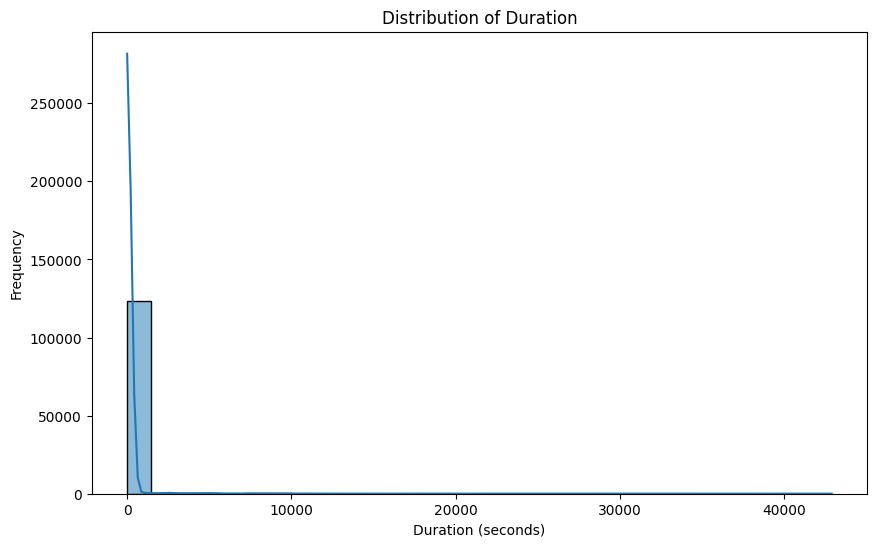

In [ ]:
# Visualization 1: Distribution of 'duration' feature
plt.figure(figsize=(10, 6))
sns.histplot(data=train_df, x='duration', bins=30, kde=True)
plt.title('Distribution of Duration')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.show()

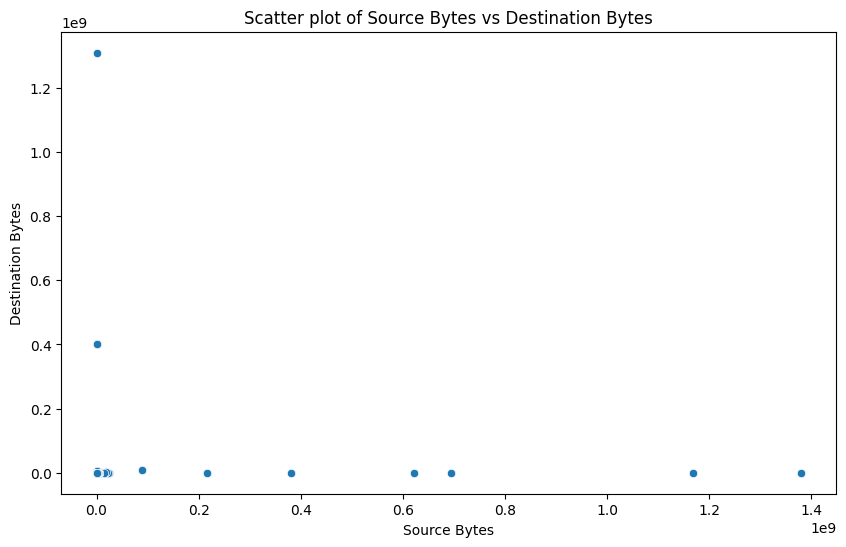

In [ ]:
# Visualization 2: Scatter plot of 'src_bytes' vs 'dst_bytes'
plt.figure(figsize=(10, 6))
sns.scatterplot(data=train_df, x='src_bytes', y='dst_bytes')
plt.title('Scatter plot of Source Bytes vs Destination Bytes')
plt.xlabel('Source Bytes')
plt.ylabel('Destination Bytes')
plt.show()

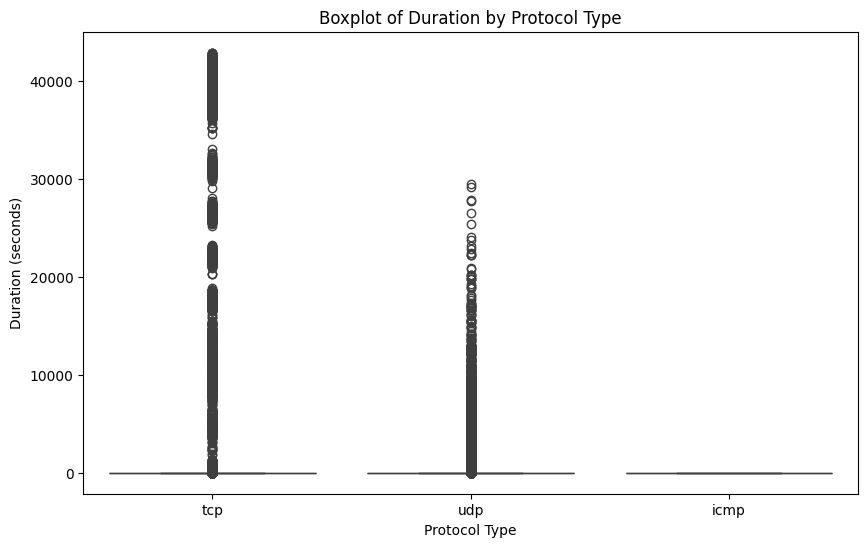

In [ ]:
# Visualization 3: Boxplot of 'protocol_type' vs 'duration'
plt.figure(figsize=(10, 6))
sns.boxplot(data=train_df, x='protocol_type', y='duration')
plt.title('Boxplot of Duration by Protocol Type')
plt.xlabel('Protocol Type')
plt.ylabel('Duration (seconds)')
plt.show()

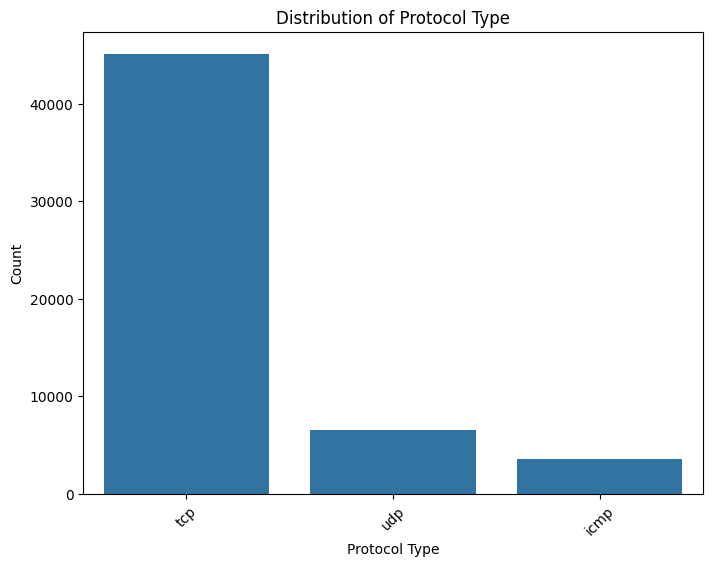

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x='protocol_type', data=train_df)
plt.title('Distribution of Protocol Type')
plt.xlabel('Protocol Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [ ]:
train_df['protocol_type'].value_counts()

protocol_type
tcp     45097
udp      6588
icmp     3611
Name: count, dtype: int64

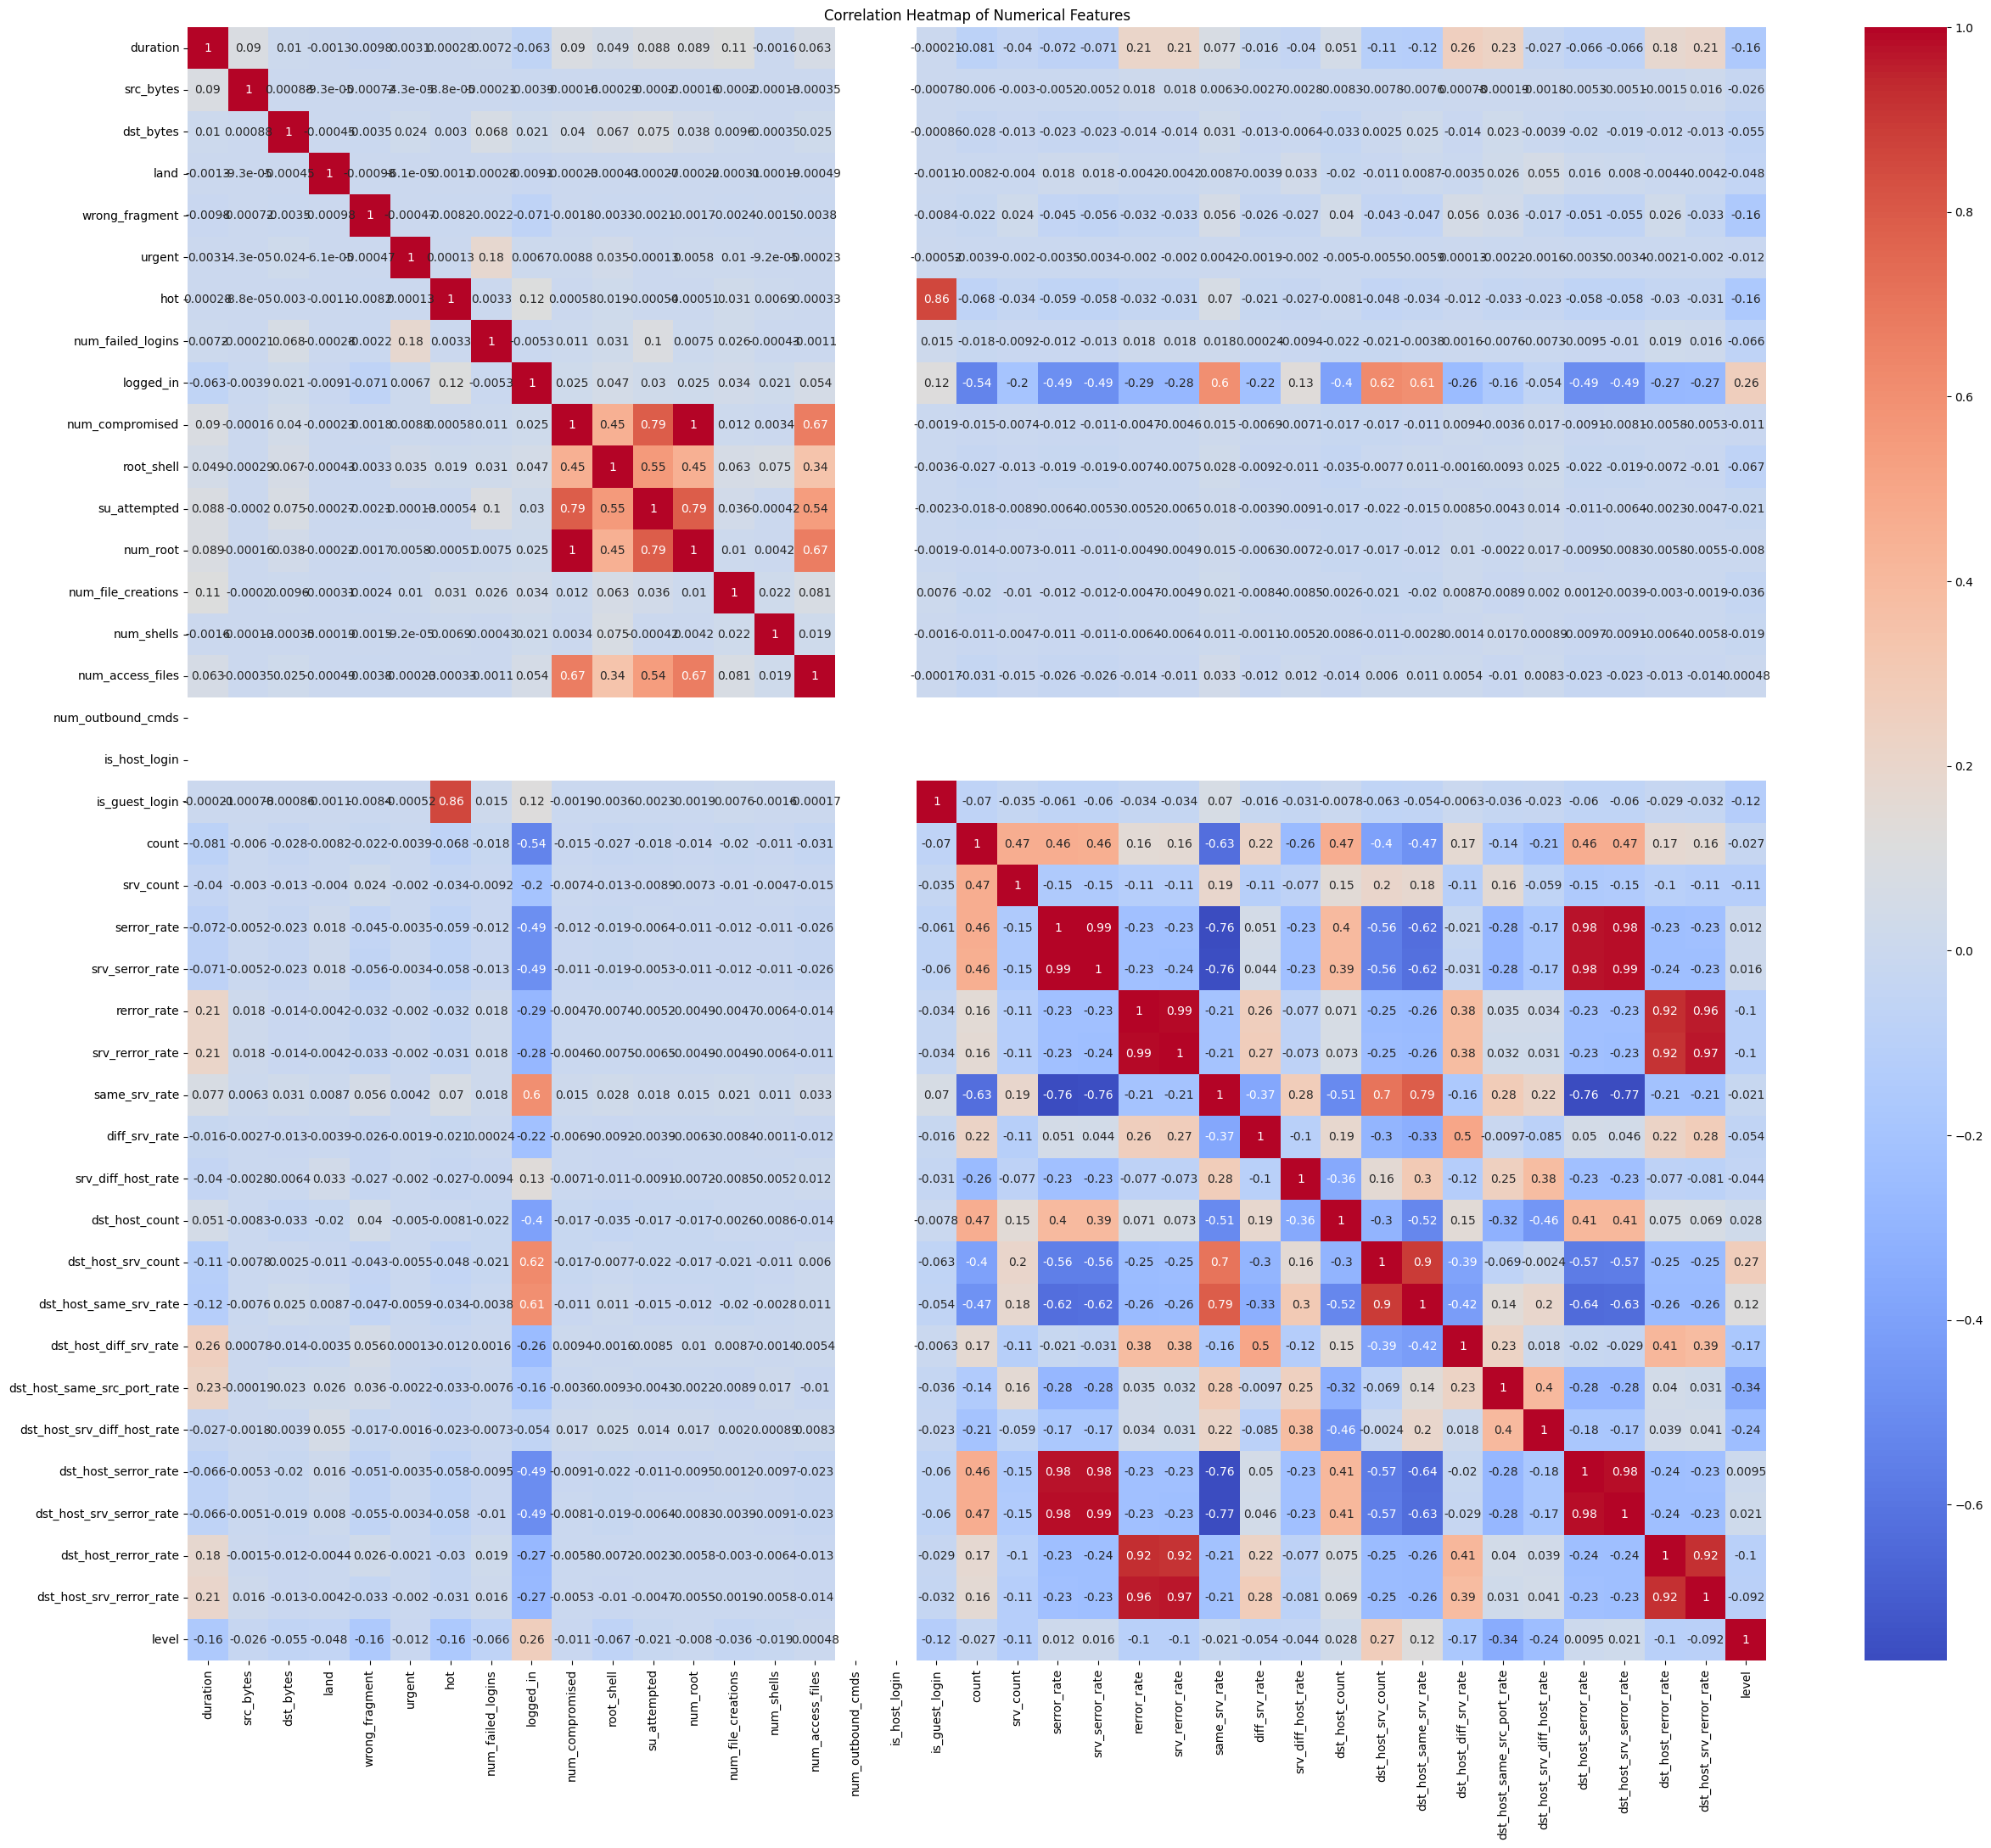

In [ ]:
# Select only numerical columns
numerical_features = train_df.select_dtypes(include=['int64', 'float64'])

# Correlation heatmap of numerical features
plt.figure(figsize=(30, 25))
sns.heatmap(numerical_features.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

In [ ]:
corr_values = numerical_features.corr()
corr_values

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,level
duration,1.000000,0.090422,0.010097,-0.001262,-0.009810,0.003092,0.000279,0.007159,-0.063422,0.090232,...,-0.111127,-0.117519,0.260028,0.232011,-0.026525,-0.066462,-0.065600,0.180703,0.205010,-0.156287
src_bytes,0.090422,1.000000,0.000885,-0.000093,-0.000720,-0.000043,-0.000088,-0.000206,-0.003943,-0.000155,...,-0.007759,-0.007560,0.000779,-0.000190,-0.001811,-0.005260,-0.005115,-0.001479,0.016092,-0.025696
dst_bytes,0.010097,0.000885,1.000000,-0.000454,-0.003529,0.023821,0.002986,0.067560,0.020572,0.039892,...,0.002516,0.024774,-0.013587,0.022654,-0.003924,-0.020270,-0.019458,-0.012273,-0.013476,-0.054722
land,-0.001262,-0.000093,-0.000454,1.000000,-0.000985,-0.000061,-0.001054,-0.000283,-0.009067,-0.000225,...,-0.011130,0.008748,-0.003505,0.026126,0.054562,0.016482,0.008035,-0.004356,-0.004233,-0.048220
wrong_fragment,-0.009810,-0.000720,-0.003529,-0.000985,1.000000,-0.000471,-0.008199,-0.002200,-0.070507,-0.001753,...,-0.043214,-0.047424,0.056222,0.035805,-0.017318,-0.051361,-0.055013,0.026471,-0.032915,-0.155809
urgent,0.003092,-0.000043,0.023821,-0.000061,-0.000471,1.000000,0.000125,0.180831,0.006675,0.008818,...,-0.005500,-0.005886,0.000132,-0.002191,-0.001558,-0.003461,-0.003382,-0.002083,-0.002024,-0.011595
hot,0.000279,-0.000088,0.002986,-0.001054,-0.008199,0.000125,1.000000,0.003339,0.115473,0.000584,...,-0.048410,-0.034276,-0.012426,-0.033269,-0.023136,-0.057735,-0.057905,-0.029656,-0.030999,-0.164331
num_failed_logins,0.007159,-0.000206,0.067560,-0.000283,-0.002200,0.180831,0.003339,1.000000,-0.005321,0.011056,...,-0.021421,-0.003827,0.001643,-0.007582,-0.007281,-0.009468,-0.010337,0.018864,0.015856,-0.066125
logged_in,-0.063422,-0.003943,0.020572,-0.009067,-0.070507,0.006675,0.115473,-0.005321,1.000000,0.024859,...,0.624556,0.605612,-0.256500,-0.159283,-0.053764,-0.492728,-0.494019,-0.273568,-0.270786,0.263864
num_compromised,0.090232,-0.000155,0.039892,-0.000225,-0.001753,0.008818,0.000584,0.011056,0.024859,1.000000,...,-0.017182,-0.011066,0.009366,-0.003583,0.016684,-0.009077,-0.008056,-0.005815,-0.005262,-0.011254


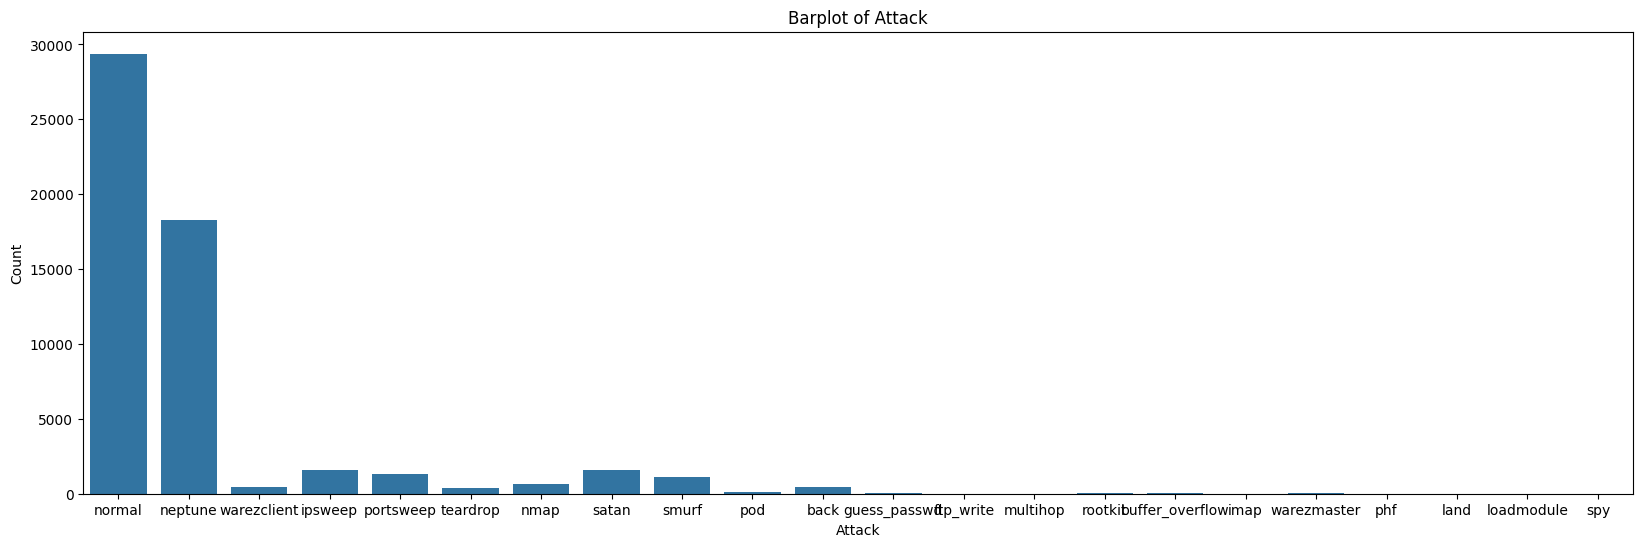

In [ ]:
# Visualization 5: Barplot of 'attack' feature
plt.figure(figsize=(20, 6))
sns.countplot(data=train_df, x='attack')
plt.title('Barplot of Attack')
plt.xlabel('Attack')
plt.ylabel('Count')
plt.show()

In [ ]:
train_df['attack'].value_counts()

attack
normal             29378
neptune            18243
satan               1587
ipsweep             1572
portsweep           1326
smurf               1139
nmap                 661
back                 439
warezclient          413
teardrop             380
pod                   76
guess_passwd          22
buffer_overflow       16
warezmaster           12
rootkit                7
multihop               5
imap                   5
land                   4
ftp_write              3
phf                    3
loadmodule             3
spy                    1
Name: count, dtype: int64

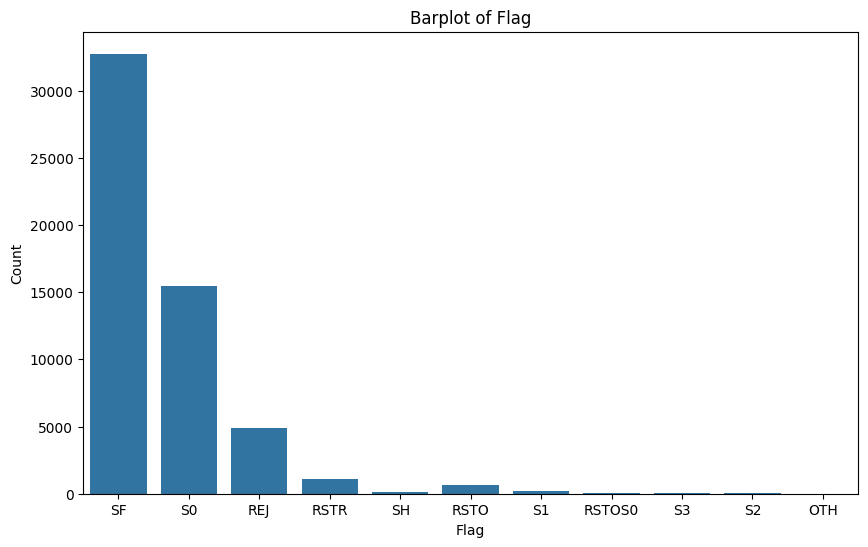

In [ ]:
# Visualization 6: Barplot of 'flag' feature
plt.figure(figsize=(10, 6))
sns.countplot(data=train_df, x='flag')
plt.title('Barplot of Flag')
plt.xlabel('Flag')
plt.ylabel('Count')
plt.show()

In [ ]:
train_df['flag'].value_counts()

flag
SF        32742
S0        15459
REJ        4901
RSTR       1105
RSTO        657
S1          173
SH          100
S2           63
RSTOS0       49
S3           31
OTH          16
Name: count, dtype: int64

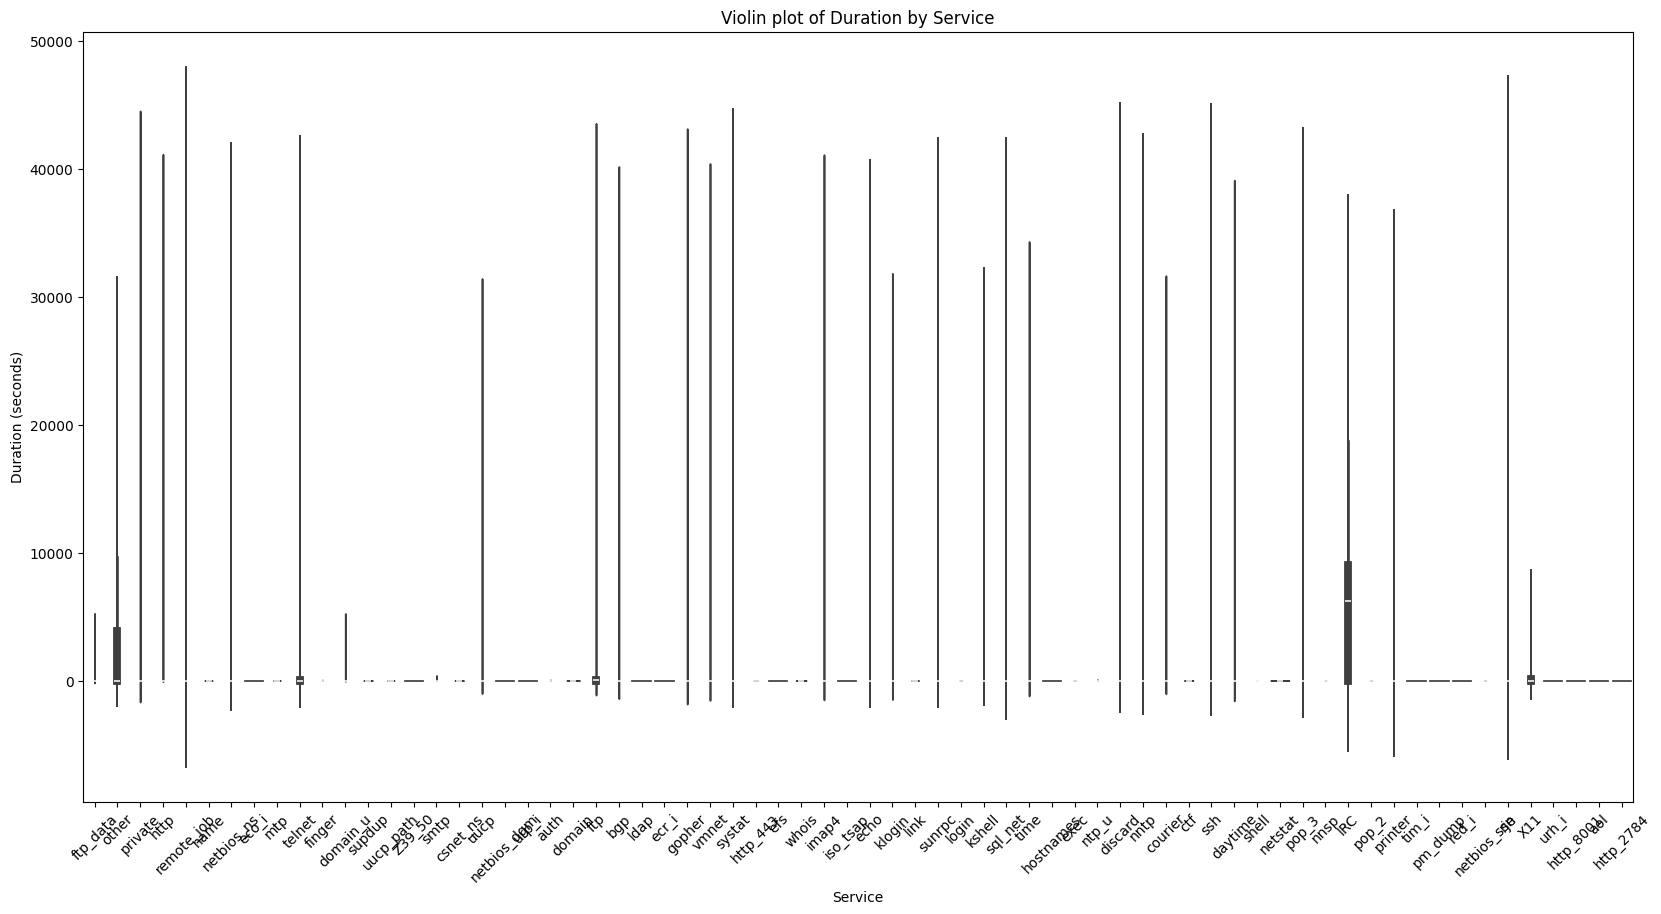

In [ ]:
# Visualization 7: Violin plot of 'service' vs 'duration'
plt.figure(figsize=(20, 10))
sns.violinplot(data=train_df, x='service', y='duration')
plt.title('Violin plot of Duration by Service')
plt.xlabel('Service')
plt.ylabel('Duration (seconds)')
plt.xticks(rotation=45)
plt.show()

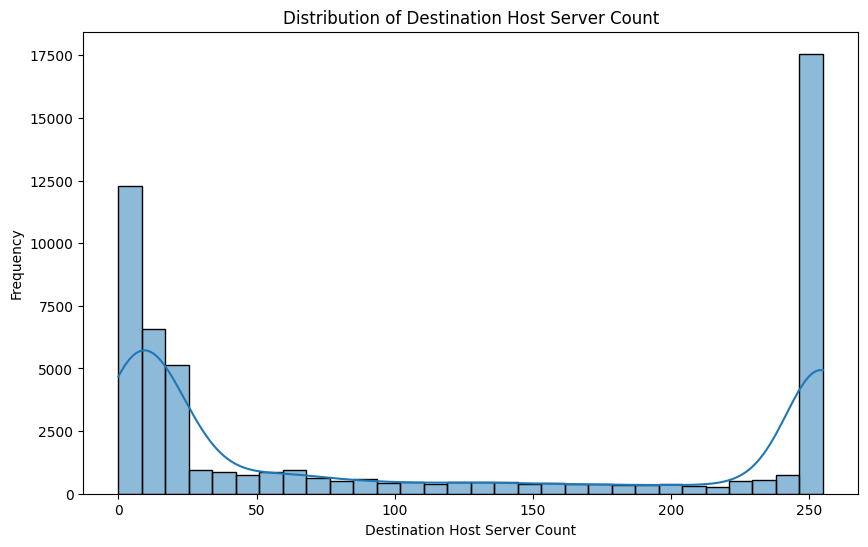

In [ ]:
# Visualization 9: Distribution of 'dst_host_srv_count'
plt.figure(figsize=(10, 6))
sns.histplot(data=train_df, x='dst_host_srv_count', bins=30, kde=True)
plt.title('Distribution of Destination Host Server Count')
plt.xlabel('Destination Host Server Count')
plt.ylabel('Frequency')
plt.show()

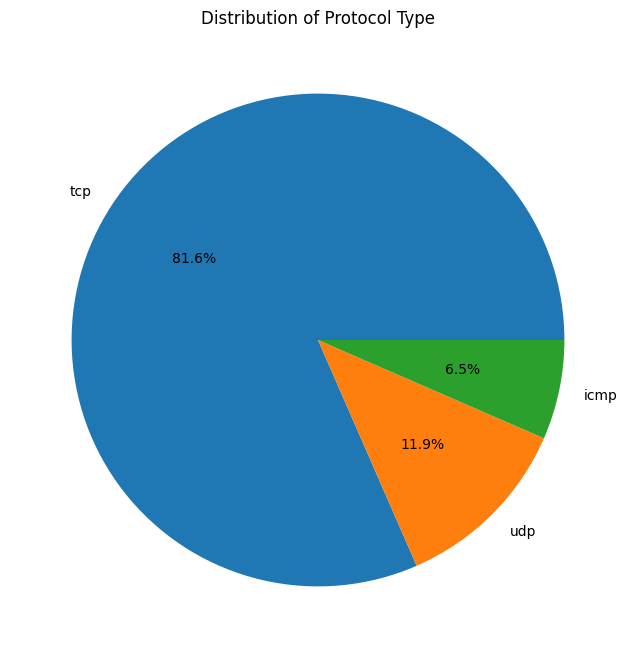

In [ ]:
# Visualization 10: Pie chart of 'protocol_type'
plt.figure(figsize=(8, 8))
train_df['protocol_type'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Protocol Type')
plt.ylabel('')
plt.show()

# **Data Preprocessing**

In [ ]:
train_df.isnull().sum()

Source                         0
Destination                    0
duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_r

In [ ]:
test_df.isnull().sum()

Source                         0
Destination                    0
duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_r

In [ ]:
train_df.columns

Index(['Source', 'Destination', 'duration', 'protocol_type', 'service', 'flag',
       'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'attack', 'level'],
      dtype='object')

In [ ]:
# Define a function to map attack types to binary classes
def map_attack_to_binary(attack):
    if attack == 'normal':
        return 'normal'
    else:
        return 'abnormal'

# Apply the mapping function to the target variable in both train_df and test_df
train_df['binary_attack'] = train_df['attack'].apply(map_attack_to_binary)
test_df['binary_attack'] = test_df['attack'].apply(map_attack_to_binary)

# Drop the original attack column from both DataFrames
train_df.drop(columns=['attack'], inplace=True)
test_df.drop(columns=['attack'], inplace=True)

In [ ]:
train_df["binary_attack"].unique()

array(['normal', 'abnormal'], dtype=object)

In [ ]:
test_df["binary_attack"].unique()

array(['abnormal', 'normal'], dtype=object)

In [ ]:
categorical_columns = train_df.select_dtypes(include=['object']).columns
print("Categorical Variables:")
for column in categorical_columns:
    print(column)

Categorical Variables:
Source
Destination
protocol_type
service
flag
binary_attack


In [ ]:
#  Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode 'protocol_type' column
train_df['protocol_type_encoded'] = label_encoder.fit_transform(train_df['protocol_type'])

# Encode 'flag' column
train_df['flag_encoded'] = label_encoder.fit_transform(train_df['flag'])

# Encode 'attack' column
train_df['attack_encoded'] = label_encoder.fit_transform(train_df['binary_attack'])

# Display the encoded columns
train_df[['protocol_type', 'protocol_type_encoded', 'flag', 'flag_encoded', 'binary_attack', 'attack_encoded']].head()

,protocol_type,protocol_type_encoded,flag,flag_encoded,binary_attack,attack_encoded
0,tcp,1,SF,9,normal,1
1,udp,2,SF,9,normal,1
2,tcp,1,S0,5,abnormal,0
3,tcp,1,SF,9,normal,1
4,tcp,1,SF,9,normal,1


In [ ]:
# Encode 'protocol_type' column
test_df['protocol_type_encoded'] = label_encoder.fit_transform(test_df['protocol_type'])

# Encode 'flag' column
test_df['flag_encoded'] = label_encoder.fit_transform(test_df['flag'])

# Encode 'attack' column
test_df['attack_encoded'] = label_encoder.fit_transform(test_df['binary_attack'])

# Display the encoded columns
test_df[['protocol_type', 'protocol_type_encoded', 'flag', 'flag_encoded', 'binary_attack', 'attack_encoded']].head()

,protocol_type,protocol_type_encoded,flag,flag_encoded,binary_attack,attack_encoded
0,tcp,1,REJ,1,abnormal,0
1,tcp,1,REJ,1,abnormal,0
2,tcp,1,SF,9,normal,1
3,icmp,0,SF,9,abnormal,0
4,tcp,1,RSTO,2,abnormal,0


In [ ]:
# Drop original columns from train_df
train_df.drop(['protocol_type', 'flag', 'binary_attack', 'service'], axis=1, inplace=True)

# Drop original columns from test_df
test_df.drop(['protocol_type', 'flag', 'binary_attack', 'service'], axis=1, inplace=True)


In [ ]:
train_df.head()

,Source,Destination,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,...,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,level,protocol_type_encoded,flag_encoded,attack_encoded
0,192.167.7.162,142.250.190.46,0,491,0,0,0,0,0,0,...,0.17,0.00,0.00,0.00,0.05,0.00,20,1,9,1
1,192.167.7.162,23.222.236.33,0,146,0,0,0,0,0,0,...,0.88,0.00,0.00,0.00,0.00,0.00,15,2,9,1
2,192.167.7.162,152.199.24.185,0,0,0,0,0,0,0,0,...,0.00,0.00,1.00,1.00,0.00,0.00,19,1,5,0
3,192.232.16.205,192.167.7.162,0,232,8153,0,0,0,0,0,...,0.03,0.04,0.03,0.01,0.00,0.01,21,1,9,1
4,74.125.9.169,192.167.7.162,0,199,420,0,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,21,1,9,1


In [ ]:
# Selecting the numerical columns
numerical_columns = ['duration', 'src_bytes', 'dst_bytes', 'num_compromised', 'num_root', 'count', 'srv_count']

# Creating a StandardScaler object
scaler = StandardScaler()

# Standardizing the selected columns
train_df[numerical_columns] = scaler.fit_transform(train_df[numerical_columns])

# Printing the standardized DataFrame
train_df.head()

,Source,Destination,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,...,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,level,protocol_type_encoded,flag_encoded,attack_encoded
0,192.167.7.162,142.250.190.46,-0.110249,-0.007679,-0.004919,0,0,0,0,0,...,0.17,0.00,0.00,0.00,0.05,0.00,20,1,9,1
1,192.167.7.162,23.222.236.33,-0.110249,-0.007737,-0.004919,0,0,0,0,0,...,0.88,0.00,0.00,0.00,0.00,0.00,15,2,9,1
2,192.167.7.162,152.199.24.185,-0.110249,-0.007762,-0.004919,0,0,0,0,0,...,0.00,0.00,1.00,1.00,0.00,0.00,19,1,5,0
3,192.232.16.205,192.167.7.162,-0.110249,-0.007723,-0.002891,0,0,0,0,0,...,0.03,0.04,0.03,0.01,0.00,0.01,21,1,9,1
4,74.125.9.169,192.167.7.162,-0.110249,-0.007728,-0.004814,0,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,21,1,9,1


In [ ]:
train_df.shape

(125973, 44)

In [ ]:
train_data = train_df.head(80000)

In [ ]:
train_data.shape

(80000, 44)

In [ ]:
# Standardizing the selected columns
test_df[numerical_columns] = scaler.fit_transform(test_df[numerical_columns])
test_df.head()

,Source,Destination,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,...,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,level,protocol_type_encoded,flag_encoded,attack_encoded
0,104.91.166.75,192.167.7.162,-0.155534,-0.021988,-0.096896,0,0,0,0,0,...,0.00,0.00,0.0,0.0,1.00,1.00,21,1,1,0
1,74.125.9.169,192.167.7.162,-0.155534,-0.021988,-0.096896,0,0,0,0,0,...,0.00,0.00,0.0,0.0,1.00,1.00,21,1,1,0
2,74.125.9.169,192.167.7.162,-0.154113,0.005473,-0.096896,0,0,0,0,0,...,0.61,0.02,0.0,0.0,0.00,0.00,21,1,9,1
3,192.232.16.76,192.167.7.162,-0.155534,-0.021946,-0.096896,0,0,0,0,0,...,1.00,0.28,0.0,0.0,0.00,0.00,15,0,9,0
4,23.78.12.183,192.167.7.162,-0.154823,-0.021988,-0.096189,0,0,0,0,0,...,0.03,0.02,0.0,0.0,0.83,0.71,11,1,2,0


In [ ]:
test_data = test_df

In [ ]:
test_data.shape

(22544, 44)

In [ ]:
train_data.columns

Index(['Source', 'Destination', 'duration', 'src_bytes', 'dst_bytes', 'land',
       'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in',
       'num_compromised', 'root_shell', 'su_attempted', 'num_root',
       'num_file_creations', 'num_shells', 'num_access_files',
       'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count',
       'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate',
       'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
       'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
       'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
       'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
       'dst_host_serror_rate', 'dst_host_srv_serror_rate',
       'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'level',
       'protocol_type_encoded', 'flag_encoded', 'attack_encoded'],
      dtype='object')

In [ ]:
# Select numerical columns
numerical_columns = train_data.select_dtypes(include='number').columns

# Compute correlation matrix for numerical columns only
correlation_matrix = train_data[numerical_columns].corr()

# Find correlation with target variable 'attack_encoded'
correlation_with_target = correlation_matrix['attack_encoded']

# Filter attributes with correlation over 0.1
attributes_over_01 = correlation_with_target[correlation_with_target > 0.1]

# Print attributes with correlation over 0.1
print("Attributes with correlation over 0.1 with 'attack_encoded':")
print(attributes_over_01)

Attributes with correlation over 0.1 with 'attack_encoded':
logged_in                 0.688780
same_srv_rate             0.752140
srv_diff_host_rate        0.120093
dst_host_srv_count        0.722297
dst_host_same_srv_rate    0.693549
level                     0.376969
protocol_type_encoded     0.280865
flag_encoded              0.647353
attack_encoded            1.000000
Name: attack_encoded, dtype: float64


In [ ]:
# List of attributes with correlation over 0.1 with 'attack_encoded'
selected_attributes = attributes_over_01.index.tolist()

# Create new DataFrames containing only selected attributes
train_data_final = train_data[selected_attributes]
test_data_final = test_data[selected_attributes]

In [ ]:
# Add 'Source' and 'Destination' columns to the selected attributes DataFrame for both train and test data
train_data_final[['Source', 'Destination']] = train_data[['Source', 'Destination']]
test_data_final[['Source', 'Destination']] = test_data[['Source', 'Destination']]

In [ ]:
train_data_final.head()

,logged_in,same_srv_rate,srv_diff_host_rate,dst_host_srv_count,dst_host_same_srv_rate,level,protocol_type_encoded,flag_encoded,attack_encoded,Source,Destination
0,0,1.00,0.00,25,0.17,20,1,9,1,192.167.7.162,142.250.190.46
1,0,0.08,0.00,1,0.00,15,2,9,1,192.167.7.162,23.222.236.33
2,0,0.05,0.00,26,0.10,19,1,5,0,192.167.7.162,152.199.24.185
3,1,1.00,0.00,255,1.00,21,1,9,1,192.232.16.205,192.167.7.162
4,1,1.00,0.09,255,1.00,21,1,9,1,74.125.9.169,192.167.7.162


In [ ]:
train_data_final["attack_encoded"].value_counts()

attack_encoded
1    42670
0    37330
Name: count, dtype: int64

In [ ]:
train_data_final.columns

Index(['logged_in', 'same_srv_rate', 'srv_diff_host_rate',
       'dst_host_srv_count', 'dst_host_same_srv_rate', 'level',
       'protocol_type_encoded', 'flag_encoded', 'attack_encoded', 'Source',
       'Destination'],
      dtype='object')

In [ ]:
# Create an empty graph
empty_graph = nx.MultiGraph()

# Add nodes to the graph for each unique source and destination
empty_graph.add_nodes_from(train_data_final["Source"], type='source')
empty_graph.add_nodes_from(train_data_final["Destination"], type='destination')

# Add edges and properties to the edges
for _, row in train_data_final.iterrows():
    # Create a variable for each properties for each edge

        loggedIn = row["logged_in"],
        sameSrvRate = row["same_srv_rate"],
        srvDiffHostRate = row["srv_diff_host_rate"]
        dstHostSrvCount = row["dst_host_srv_count"],
        dstHostSameSrvRate = row['dst_host_same_srv_rate'],
        Level = row['level'],
        protocolTypeEncoded = row["protocol_type_encoded"],
        flagEncoded = row["flag_encoded"]


        empty_graph.add_edge(row['Source'], row['Destination'], loggedIn = loggedIn , sameSrvRate = sameSrvRate , srvDiffHostRate = srvDiffHostRate ,
               dstHostSrvCount = dstHostSrvCount , dstHostSameSrvRate =  dstHostSameSrvRate , Level = Level ,  protocolTypeEncoded =  protocolTypeEncoded ,
               flagEncoded =  flagEncoded)

In [ ]:
# Getting the number of nodes and edges in the graph created
number_of_nodes = empty_graph.number_of_nodes()
number_of_edges = empty_graph.number_of_edges()

# Print the number of nodes and edges
print("Number of nodes in the graph:", number_of_nodes)
print("Number of edges in the graph:", number_of_edges)

Number of nodes in the graph: 330
Number of edges in the graph: 80000


In [ ]:
# Converting the created graph to an adjacency matrix
adjacencyMatrix = nx.adjacency_matrix(empty_graph).todense()

# checking the shape of this created matrix
adjacencyMatrix.shape

(330, 330)

In [ ]:
# Obtain a subset of nodes from the graph
selected_nodes = list(empty_graph.nodes())[:5]

# Extract the attributes of the selected nodes
properties_of_nodes = nx.get_node_attributes(empty_graph, 'type')

# Display the attributes of the selected nodes
for node_id in selected_nodes:
    print(f"Node: {node_id}, The Properties: {properties_of_nodes[node_id]}")

Node: 192.167.7.162, The Properties: destination
Node: 192.232.16.205, The Properties: destination
Node: 74.125.9.169, The Properties: destination
Node: 23.56.99.8, The Properties: destination
Node: 104.91.166.113, The Properties: destination


In [ ]:
# getting edges from the graph
size_of_sample = 2
for i, edge in enumerate(empty_graph.edges()):
    print(empty_graph.get_edge_data(*edge))
    if i >= size_of_sample - 1:
        break

{0: {'loggedIn': (0,), 'sameSrvRate': (1.0,), 'srvDiffHostRate': 0.0, 'dstHostSrvCount': (25,), 'dstHostSameSrvRate': (0.17,), 'Level': (20,), 'protocolTypeEncoded': (1,), 'flagEncoded': 9}, 1: {'loggedIn': (1,), 'sameSrvRate': (1.0,), 'srvDiffHostRate': 0.22, 'dstHostSrvCount': (255,), 'dstHostSameSrvRate': (1.0,), 'Level': (21,), 'protocolTypeEncoded': (1,), 'flagEncoded': 9}, 2: {'loggedIn': (1,), 'sameSrvRate': (1.0,), 'srvDiffHostRate': 0.0, 'dstHostSrvCount': (255,), 'dstHostSameSrvRate': (1.0,), 'Level': (21,), 'protocolTypeEncoded': (1,), 'flagEncoded': 9}, 3: {'loggedIn': (0,), 'sameSrvRate': (0.15,), 'srvDiffHostRate': 0.0, 'dstHostSrvCount': (17,), 'dstHostSameSrvRate': (0.07,), 'Level': (18,), 'protocolTypeEncoded': (1,), 'flagEncoded': 1}, 4: {'loggedIn': (0,), 'sameSrvRate': (0.05,), 'srvDiffHostRate': 0.0, 'dstHostSrvCount': (10,), 'dstHostSameSrvRate': (0.04,), 'Level': (21,), 'protocolTypeEncoded': (1,), 'flagEncoded': 5}, 5: {'loggedIn': (1,), 'sameSrvRate': (1.0,), '

In [ ]:
# getting the properties errors of all the edges
properties_of_edges = nx.get_edge_attributes(empty_graph, 'errors')

# number of edges counted by property the value
count_of_edge_by_property = Counter(properties_of_edges.values())

# Print the count of edges by property value
for property_value, count in count_of_edge_by_property.items():
    print(f"Property value: {property_value}, Count: {count}")

In [ ]:
# Prepare the data for input into the model
list_of_edges = list(empty_graph.edges(data=True))
list(list_of_edges[i][2].values())

[(1,), (1.0,), 0.22, (255,), (1.0,), (21,), (1,), 9]

In [ ]:
import torch
from torch.nn import Linear, Module, ReLU

from torch_geometric.nn import GCNConv  # Assuming you use torch_geometric

class AnomalyGNN(Module):
  def __init__(self, input_dim, hidden_dim):
    super(AnomalyGNN, self).__init__()
    self.conv1 = GCNConv(input_dim, hidden_dim)  # GNN Layer
    self.fc1 = Linear(hidden_dim, hidden_dim)
    self.fc2 = Linear(hidden_dim, 1)

  def forward(self, x, edge_index):
    # Pass node features and edge indices through GCN layer
    x = self.conv1(x, edge_index)
    x = ReLU()(x)

    x = self.fc1(x)
    x = ReLU()(x)
    x = self.fc2(x)
    return x.squeeze(-1)

# preparing the data as input
list_of_edges = list(empty_graph.edges(data=True))
x = []
for edge in list_of_edges:
    values_of_edges = list(edge[2].values())
    values_of_edges = [float(i[0]) if type(i) == tuple and type(i[0]) == str else i[0] if type(i) == tuple else i for i in values_of_edges]
    x.append(values_of_edges)
x = torch.tensor(x, dtype=torch.float)

In [ ]:
class AnomalyGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(AnomalyGNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x.squeeze(-1)

# preparing the data as input
list_of_edges = list(empty_graph.edges(data=True))
x = []
for edge in list_of_edges:
    values_of_edges = list(edge[2].values())
    values_of_edges = [float(i[0]) if type(i) == tuple and type(i[0]) == str else i[0] if type(i) == tuple else i for i in values_of_edges]
    x.append(values_of_edges)
x = torch.tensor(x, dtype=torch.float)

In [ ]:
target = torch.tensor(train_data_final['attack_encoded'].values, dtype=torch.float)
# Define the architecture of the model
input_dim = len(x[0])
hidden_dim = 16
model = AnomalyGNN(input_dim, hidden_dim)
epochs=200

# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train the created model
for i in range(epochs):
    # Forward pass
    output = model(x)
    # Calculate the loss
    loss = criterion(output, target)
    if i % 5 == 0:
        print(f'Epoch: {i}, Loss: {loss.item()}')
    # Zero the gradients
    optimizer.zero_grad()
    # Perform backpropagation
    loss.backward()
    # Update the parameters
    optimizer.step()

Epoch: 0, Loss: 9.089709281921387
Epoch: 5, Loss: 2.901996374130249
Epoch: 10, Loss: 2.309051275253296
Epoch: 15, Loss: 1.3510727882385254
Epoch: 20, Loss: 1.3787850141525269
Epoch: 25, Loss: 0.752344012260437
Epoch: 30, Loss: 0.8740768432617188
Epoch: 35, Loss: 0.8597771525382996
Epoch: 40, Loss: 0.730589747428894
Epoch: 45, Loss: 0.7072412371635437
Epoch: 50, Loss: 0.701080322265625
Epoch: 55, Loss: 0.7019975781440735
Epoch: 60, Loss: 0.7014990448951721
Epoch: 65, Loss: 0.7008956074714661
Epoch: 70, Loss: 0.6982117891311646
Epoch: 75, Loss: 0.6956666707992554
Epoch: 80, Loss: 0.6938745379447937
Epoch: 85, Loss: 0.6927638649940491
Epoch: 90, Loss: 0.6928366422653198
Epoch: 95, Loss: 0.6923731565475464
Epoch: 100, Loss: 0.6921104788780212
Epoch: 105, Loss: 0.6920619010925293
Epoch: 110, Loss: 0.6918741464614868
Epoch: 115, Loss: 0.6918041706085205
Epoch: 120, Loss: 0.6917350888252258
Epoch: 125, Loss: 0.6916750073432922
Epoch: 130, Loss: 0.6916305422782898
Epoch: 135, Loss: 0.691587328

In [ ]:
train_data_final.columns

Index(['logged_in', 'same_srv_rate', 'srv_diff_host_rate',
       'dst_host_srv_count', 'dst_host_same_srv_rate', 'level',
       'protocol_type_encoded', 'flag_encoded', 'attack_encoded', 'Source',
       'Destination'],
      dtype='object')

In [ ]:
test_data["attack_encoded"].value_counts()

attack_encoded
0    12833
1     9711
Name: count, dtype: int64

In [ ]:
# Extract features from test data (assuming relevant features are in specific columns)
test_features = test_data_final[['logged_in', 'same_srv_rate', 'srv_diff_host_rate',
       'dst_host_srv_count', 'dst_host_same_srv_rate', 'level',
       'protocol_type_encoded', 'flag_encoded']]

# Convert features to a PyTorch tensor
x_test = torch.tensor(test_features.values, dtype=torch.float)  # given features are numerical

# Make predictions using the model
model.eval()
output_test = model(x_test)

In [ ]:
# Convert predictions to binary labels (anomalous or normal) based on a chosen threshold
threshold = 0.1
y_pred = (output_test > threshold).float()

# Get the ground truth labels from the target variable in test data
y_true = test_data_final['attack_encoded'].values

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

Accuracy: 0.67374911284599
Precision: 0.7351330731574033
Recall: 0.7042901699688279
F1-Score: 0.6687371186114106


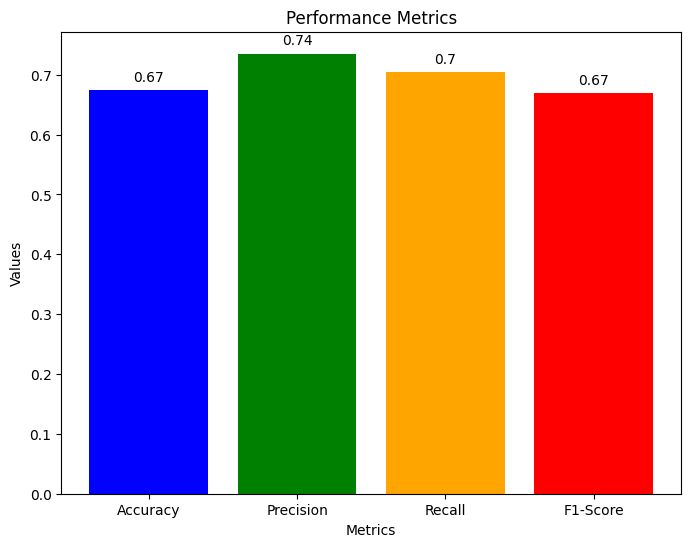

In [ ]:
import matplotlib.pyplot as plt
# Metric names
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

# Metric values
values = [0.67374911284599, 0.7351330731574033, 0.7042901699688279, 0.6687371186114106]

# Create bar plot
plt.figure(figsize=(8, 6))
bars = plt.bar(metrics, values, color=['blue', 'green', 'orange', 'red'])

# Add annotations on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

# Adding title and labels
plt.title('Performance Metrics')
plt.xlabel('Metrics')
plt.ylabel('Values')

# Show plot
plt.show()